In [1]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 40.5 MB/s eta 0:00:00


In [7]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 30.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 87.0 MB/s eta 0:00:00


In [6]:
# 5 clients for 10 rounds

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import numpy as np
import networkx as nx
import random

# def get_diag_hessian(grad_params, model):
#     diag_hessian = []
#     for grad in grad_params:
#         grad = grad.view(-1)
#         layer_diag_hessian = []
#         for i in range(len(grad)):
#             second_grad = torch.autograd.grad(grad[i], model.parameters(), retain_graph=True)
#             second_grad = torch.cat([g.contiguous().view(-1) for g in second_grad])
#             layer_diag_hessian.append(second_grad[i])
#         diag_hessian.append(layer_diag_hessian)
#     return diag_hessian

def hutchinson(model, loss, num_samples=10):
    """
    Compute the Hessian-vector product (Hv) using the Hutchinson method.

    :param model: PyTorch model
    :param loss: scalar loss value (PyTorch tensor)
    :param num_samples: number of random vectors to be sampled
    :return: list of Hessian-vector products (one per model parameter)
    """
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    hessian_vector_products = []

    for _ in range(num_samples):
        random_vector = [torch.randn_like(p) for p in model.parameters()]
        grad_params_vector = torch.autograd.grad(grad_params, model.parameters(), grad_outputs=random_vector, retain_graph=True)
        hessian_vector_product = [torch.sum(gvp * rv) for gvp, rv in zip(grad_params_vector, random_vector)]  # Changed this line
        hessian_vector_products.append(hessian_vector_product)

    return hessian_vector_products

# Additional imports
from torch.autograd import Variable

# Model Definition
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the EMNIST dataset
train_dataset = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.EMNIST(root="./data", split="balanced", train=False, download=True, transform=transforms.ToTensor())

def get_top_k_eigenvectors(hessian_vector_products, k):
    """
    Compute the top k eigenvectors of the Hessian matrix using the output from the Hutchinson method.

    :param hessian_vector_products: list of Hessian-vector products
    :param k: number of top eigenvectors to compute
    :return: list of top k eigenvectors
    """
    hessian_matrix = np.column_stack(hessian_vector_products)

    # Calculate the covariance matrix of the Hessian
    cov_matrix = np.cov(hessian_matrix)

    # Calculate the top k eigenvectors
    _, eigenvectors = np.linalg.eigh(cov_matrix)
    top_k_eigenvectors = eigenvectors[:, -k:]

    return top_k_eigenvectors

# Hyperparameters
num_clients = 5
num_rounds = 10
num_epochs = 5
learning_rate = 0.01
batch_size = 16

# Create client subsets
subset_length = math.ceil(len(train_dataset) / num_clients)
client_data = []
for i in range(num_clients):
    start_idx = i * subset_length
    end_idx = min((i + 1) * subset_length, len(train_dataset))
    subset = torch.utils.data.Subset(train_dataset, range(start_idx, end_idx))
    client_data.append(subset)

# Initialize global model and client models
global_model = TwoLayerNet(784, 256, 47)
client_models = [TwoLayerNet(784, 256, 47) for _ in range(num_clients)]

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Create a network graph
G = nx.Graph()
G.add_nodes_from(range(num_clients))

# Add random edges
for _ in range(num_clients):
    G.add_edge(random.randint(0, num_clients-1), random.randint(0, num_clients-1))

# CONNECT Algorithm
for r in range(num_rounds):
    print(f"Round {r+1}/{num_rounds}")

    # Train local models
    for i in range(num_clients):
        optimizer = optim.SGD(client_models[i].parameters(), lr=learning_rate)
        train_loader = torch.utils.data.DataLoader(client_data[i], batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = client_models[i](data.view(data.shape[0], -1))
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        # Calculate Hessian and top-k eigenvectors for each client's local model
        k = 2  # The number of top eigenvectors to consider
        for i in range(num_clients):
            optimizer.zero_grad()
            output = client_models[i](data.view(data.shape[0], -1))
            loss = criterion(output, target)
            grad_params = torch.autograd.grad(loss, client_models[i].parameters(), create_graph=True)
            hessian_vector_products = hutchinson(client_models[i], loss, num_samples=10)
            top_k_eigenvectors_list = get_top_k_eigenvectors(hessian_vector_products, k)
            client_models[i].top_k_eigenvectors_list = top_k_eigenvectors_list


    # Aggregate client models in the graph
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        state_dicts = [client_models[neighbor].state_dict() for neighbor in neighbors]
        state_dicts.append(client_models[node].state_dict())

        averaged_state_dict = {}
        for key in client_models[node].state_dict().keys():
            averaged_state_dict[key] = torch.stack([state_dict[key].data for state_dict in state_dicts], dim=0).mean(dim=0)
        client_models[node].load_state_dict(averaged_state_dict)

    # Update global model
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key].data for i in range(num_clients)], dim=0).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

# Evaluation
global_model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = global_model(data.view(data.shape[0], -1))
        _, pred = torch.max(output.data, 1)
        total += target.size(0)
        correct += (pred == target).sum().item()

accuracy = 100 * correct / total
print('Global Model Test set: Accuracy: {}/{} ({:.2f}%)'.format(correct, total, accuracy))


  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 5171/18800 (27.51%)


In [7]:
# 15 clients

Testing with parameters: {'num_clients': 10}
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 660/18800 (3.51%)
Testing with parameters: {'num_clients': 20}
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 812/18800 (4.32%)
Testing with parameters: {'num_clients': 30}
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 1387/18800 (7.38%)
Testing with parameters: {'num_clients': 40}
Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 610/18800 (3.24%)


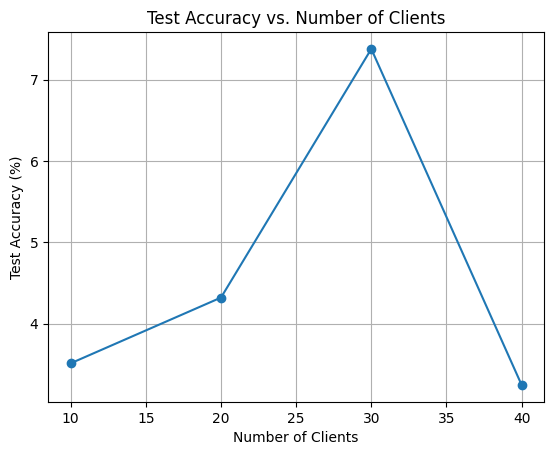

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import numpy as np
import networkx as nx
import random
from sklearn.model_selection import ParameterGrid

# def get_diag_hessian(grad_params, model):
#     diag_hessian = []
#     for grad in grad_params:
#         grad = grad.view(-1)
#         layer_diag_hessian = []
#         for i in range(len(grad)):
#             second_grad = torch.autograd.grad(grad[i], model.parameters(), retain_graph=True)
#             second_grad = torch.cat([g.contiguous().view(-1) for g in second_grad])
#             layer_diag_hessian.append(second_grad[i])
#         diag_hessian.append(layer_diag_hessian)
#     return diag_hessian

def hutchinson(model, loss, num_samples=10):
    """
    Compute the Hessian-vector product (Hv) using the Hutchinson method.

    :param model: PyTorch model
    :param loss: scalar loss value (PyTorch tensor)
    :param num_samples: number of random vectors to be sampled
    :return: list of Hessian-vector products (one per model parameter)
    """
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    hessian_vector_products = []

    for _ in range(num_samples):
        random_vector = [torch.randn_like(p) for p in model.parameters()]
        grad_params_vector = torch.autograd.grad(grad_params, model.parameters(), grad_outputs=random_vector, retain_graph=True)
        hessian_vector_product = [torch.sum(gvp * rv) for gvp, rv in zip(grad_params_vector, random_vector)]  # Changed this line
        hessian_vector_products.append(hessian_vector_product)

    return hessian_vector_products

# Additional imports
from torch.autograd import Variable

# Model Definition
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the EMNIST dataset
train_dataset = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.EMNIST(root="./data", split="balanced", train=False, download=True, transform=transforms.ToTensor())

# Create a parameter grid for the number of clients
param_grid = {'num_clients': [10, 20, 30, 40]}
grid = ParameterGrid(param_grid)

# Store the results of each experiment
results = []

def get_top_k_eigenvectors(hessian_vector_products, k):
    """
    Compute the top k eigenvectors of the Hessian matrix using the output from the Hutchinson method.

    :param hessian_vector_products: list of Hessian-vector products
    :param k: number of top eigenvectors to compute
    :return: list of top k eigenvectors
    """
    hessian_matrix = np.column_stack(hessian_vector_products)

    # Calculate the covariance matrix of the Hessian
    cov_matrix = np.cov(hessian_matrix)

    # Calculate the top k eigenvectors
    _, eigenvectors = np.linalg.eigh(cov_matrix)
    top_k_eigenvectors = eigenvectors[:, -k:]

    return top_k_eigenvectors

# Hyperparameters

num_rounds = 10
num_epochs = 5
learning_rate = 0.01
batch_size = 16



for params in grid:
    print(f"Testing with parameters: {params}")
    num_clients = params['num_clients']
    # Create client subsets
    subset_length = math.ceil(len(train_dataset) / num_clients)
    client_data = []
    for i in range(num_clients):
        start_idx = i * subset_length
        end_idx = min((i + 1) * subset_length, len(train_dataset))
        subset = torch.utils.data.Subset(train_dataset, range(start_idx, end_idx))
        client_data.append(subset)

    # Initialize global model and client models
    global_model = TwoLayerNet(784, 256, 47)
    client_models = [TwoLayerNet(784, 256, 47) for _ in range(num_clients)]

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss()

    # Create a network graph
    G = nx.Graph()
    G.add_nodes_from(range(num_clients))
    # Set the number of clients and perform the CONNECT Algorithm with the modified number of clients
    num_clients = params['num_clients']
    # Add random edges
    for _ in range(num_clients):
        G.add_edge(random.randint(0, num_clients-1), random.randint(0, num_clients-1))

    # CONNECT Algorithm
    for r in range(num_rounds):
        print(f"Round {r+1}/{num_rounds}")

        # Train local models
        for i in range(num_clients):
            optimizer = optim.SGD(client_models[i].parameters(), lr=learning_rate)
            train_loader = torch.utils.data.DataLoader(client_data[i], batch_size=batch_size, shuffle=True)

            for epoch in range(num_epochs):
                for batch_idx, (data, target) in enumerate(train_loader):
                    optimizer.zero_grad()
                    output = client_models[i](data.view(data.shape[0], -1))
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

            # Calculate Hessian and top-k eigenvectors for each client's local model
            k = 2  # The number of top eigenvectors to consider
            for i in range(num_clients):
                optimizer.zero_grad()
                output = client_models[i](data.view(data.shape[0], -1))
                loss = criterion(output, target)
                grad_params = torch.autograd.grad(loss, client_models[i].parameters(), create_graph=True)
                hessian_vector_products = hutchinson(client_models[i], loss, num_samples=10)
                top_k_eigenvectors_list = get_top_k_eigenvectors(hessian_vector_products, k)
                client_models[i].top_k_eigenvectors_list = top_k_eigenvectors_list


        # Aggregate client models in the graph
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            state_dicts = [client_models[neighbor].state_dict() for neighbor in neighbors]
            state_dicts.append(client_models[node].state_dict())

            averaged_state_dict = {}
            for key in client_models[node].state_dict().keys():
                averaged_state_dict[key] = torch.stack([state_dict[key].data for state_dict in state_dicts], dim=0).mean(dim=0)
            client_models[node].load_state_dict(averaged_state_dict)

        # Update global model
        global_state_dict = global_model.state_dict()
        for key in global_state_dict.keys():
            global_state_dict[key] = torch.stack([client_models[i].state_dict()[key].data for i in range(num_clients)], dim=0).mean(dim=0)
        global_model.load_state_dict(global_state_dict)

        # Evaluation
    global_model.eval()
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model(data.view(data.shape[0], -1))
            _, pred = torch.max(output.data, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()

    accuracy = 100 * correct / total
    print('Global Model Test set: Accuracy: {}/{} ({:.2f}%)'.format(correct, total, accuracy))

    # Save the results
    results.append({'params': params, 'accuracy': accuracy})
# Plot the graph
num_clients_list = [result['params']['num_clients'] for result in results]
accuracy_list = [result['accuracy'] for result in results]

plt.plot(num_clients_list, accuracy_list, marker='o')
plt.xlabel('Number of Clients')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs. Number of Clients')
plt.grid()
plt.show()


In [ ]:
# 25 clients

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import numpy as np
import networkx as nx
import random

# def get_diag_hessian(grad_params, model):
#     diag_hessian = []
#     for grad in grad_params:
#         grad = grad.view(-1)
#         layer_diag_hessian = []
#         for i in range(len(grad)):
#             second_grad = torch.autograd.grad(grad[i], model.parameters(), retain_graph=True)
#             second_grad = torch.cat([g.contiguous().view(-1) for g in second_grad])
#             layer_diag_hessian.append(second_grad[i])
#         diag_hessian.append(layer_diag_hessian)
#     return diag_hessian

def hutchinson(model, loss, num_samples=10):
    """
    Compute the Hessian-vector product (Hv) using the Hutchinson method.

    :param model: PyTorch model
    :param loss: scalar loss value (PyTorch tensor)
    :param num_samples: number of random vectors to be sampled
    :return: list of Hessian-vector products (one per model parameter)
    """
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    hessian_vector_products = []

    for _ in range(num_samples):
        random_vector = [torch.randn_like(p) for p in model.parameters()]
        grad_params_vector = torch.autograd.grad(grad_params, model.parameters(), grad_outputs=random_vector, retain_graph=True)
        hessian_vector_product = [torch.sum(gvp * rv) for gvp, rv in zip(grad_params_vector, random_vector)]  # Changed this line
        hessian_vector_products.append(hessian_vector_product)

    return hessian_vector_products

# Additional imports
from torch.autograd import Variable

# Model Definition
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Load the EMNIST dataset
train_dataset = datasets.EMNIST(root="./data", split="balanced", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.EMNIST(root="./data", split="balanced", train=False, download=True, transform=transforms.ToTensor())

def get_top_k_eigenvectors(hessian_vector_products, k):
    """
    Compute the top k eigenvectors of the Hessian matrix using the output from the Hutchinson method.

    :param hessian_vector_products: list of Hessian-vector products
    :param k: number of top eigenvectors to compute
    :return: list of top k eigenvectors
    """
    hessian_matrix = np.column_stack(hessian_vector_products)

    # Calculate the covariance matrix of the Hessian
    cov_matrix = np.cov(hessian_matrix)

    # Calculate the top k eigenvectors
    _, eigenvectors = np.linalg.eigh(cov_matrix)
    top_k_eigenvectors = eigenvectors[:, -k:]

    return top_k_eigenvectors

# Hyperparameters
num_clients = 25
num_rounds = 10
num_epochs = 5
learning_rate = 0.01
batch_size = 16

# Create client subsets
subset_length = math.ceil(len(train_dataset) / num_clients)
client_data = []
for i in range(num_clients):
    start_idx = i * subset_length
    end_idx = min((i + 1) * subset_length, len(train_dataset))
    subset = torch.utils.data.Subset(train_dataset, range(start_idx, end_idx))
    client_data.append(subset)

# Initialize global model and client models
global_model = TwoLayerNet(784, 256, 47)
client_models = [TwoLayerNet(784, 256, 47) for _ in range(num_clients)]

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Create a network graph
G = nx.Graph()
G.add_nodes_from(range(num_clients))

# Add random edges
for _ in range(num_clients):
    G.add_edge(random.randint(0, num_clients-1), random.randint(0, num_clients-1))

# CONNECT Algorithm
for r in range(num_rounds):
    print(f"Round {r+1}/{num_rounds}")

    # Train local models
    for i in range(num_clients):
        optimizer = optim.SGD(client_models[i].parameters(), lr=learning_rate)
        train_loader = torch.utils.data.DataLoader(client_data[i], batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = client_models[i](data.view(data.shape[0], -1))
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

        # Calculate Hessian and top-k eigenvectors for each client's local model
        k = 2  # The number of top eigenvectors to consider
        for i in range(num_clients):
            optimizer.zero_grad()
            output = client_models[i](data.view(data.shape[0], -1))
            loss = criterion(output, target)
            grad_params = torch.autograd.grad(loss, client_models[i].parameters(), create_graph=True)
            hessian_vector_products = hutchinson(client_models[i], loss, num_samples=10)
            top_k_eigenvectors_list = get_top_k_eigenvectors(hessian_vector_products, k)
            client_models[i].top_k_eigenvectors_list = top_k_eigenvectors_list


    # Aggregate client models in the graph
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        state_dicts = [client_models[neighbor].state_dict() for neighbor in neighbors]
        state_dicts.append(client_models[node].state_dict())

        averaged_state_dict = {}
        for key in client_models[node].state_dict().keys():
            averaged_state_dict[key] = torch.stack([state_dict[key].data for state_dict in state_dicts], dim=0).mean(dim=0)
        client_models[node].load_state_dict(averaged_state_dict)

    # Update global model
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_models[i].state_dict()[key].data for i in range(num_clients)], dim=0).mean(dim=0)
    global_model.load_state_dict(global_state_dict)

# Evaluation
global_model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = global_model(data.view(data.shape[0], -1))
        _, pred = torch.max(output.data, 1)
        total += target.size(0)
        correct += (pred == target).sum().item()

accuracy = 100 * correct / total
print('Global Model Test set: Accuracy: {}/{} ({:.2f}%)'.format(correct, total, accuracy))


Round 1/10
Round 2/10
Round 3/10
Round 4/10
Round 5/10
Round 6/10
Round 7/10
Round 8/10
Round 9/10
Round 10/10
Global Model Test set: Accuracy: 833/18800 (4.43%)
